In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [11]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Load your dataset
df = pd.read_csv("Roman_Urdu1.csv", encoding = "latin1")
df.head()

,tweets,label
0,14 crore ke project ko banaa ke 14 arab khaa ...,H
1,Abhi bari hojao phir siyasat ki baat karna,H
2,Allah aap ko sehat zindagi dy taky aap choron...,H
3,antiii bhaii full gussy m h,H
4,Beshak bahar se parh ke aaya ho lekin bilawal...,H


In [13]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [14]:
# Define a custom dataset class
class RomanUrduDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [15]:
# Define hyperparameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10

In [16]:
# Split dataset into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['tweets'].values, df['label'].values, test_size=0.2, random_state=42
)

In [17]:
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


OSError: Can't load tokenizer for 'distilbert-base-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'distilbert-base-uncased' is the correct path to a directory containing all relevant files for a DistilBertTokenizer tokenizer.

In [18]:
# Create dataloaders
train_dataset = RomanUrduDataset(train_texts, train_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = RomanUrduDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NameError: name 'tokenizer' is not defined

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


In [11]:
from tqdm import tqdm

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_accuracy = correct / total
        train_loss /= len(train_loader)

        progress_bar.set_postfix({'loss': train_loss, 'accuracy': train_accuracy})

    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')


Epoch 1/10, Loss: 0.0006, Accuracy: 0.7897


Epoch 2/10, Loss: 0.0002, Accuracy: 0.9017


Epoch 3/10, Loss: 0.0008, Accuracy: 0.9481


Epoch 4/10, Loss: 0.0000, Accuracy: 0.9660


Epoch 5/10, Loss: 0.0001, Accuracy: 0.9781


Epoch 6/10, Loss: 0.0004, Accuracy: 0.9836


Epoch 7/10, Loss: 0.0001, Accuracy: 0.9880


Epoch 8/10, Loss: 0.0000, Accuracy: 0.9904


Epoch 9/10, Loss: 0.0000, Accuracy: 0.9927


Epoch 10/10, Loss: 0.0001, Accuracy: 0.9942


In [17]:
# Saving the trained model and tokenizer
model_save_path = "./hate_speech_model"
tokenizer_save_path = "./tokenizer"

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved.")


Model and tokenizer saved.


In [13]:
# Load the model and tokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_load_path = "./hate_speech_model"
tokenizer_load_path = "./tokenizer"

model = DistilBertForSequenceClassification.from_pretrained(model_load_path)
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_load_path)

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model and tokenizer loaded.")


Model and tokenizer loaded.


In [14]:
# Move model to the device
model.to(device)
print("Model moved to the device.")

Model moved to the device.


In [23]:
# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    progress_bar = tqdm(test_loader, desc='Evaluation', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.8825, Precision: 0.8759, Recall: 0.8874, F1-score: 0.8816
Confusion Matrix:
[[890 124]
 [111 875]]


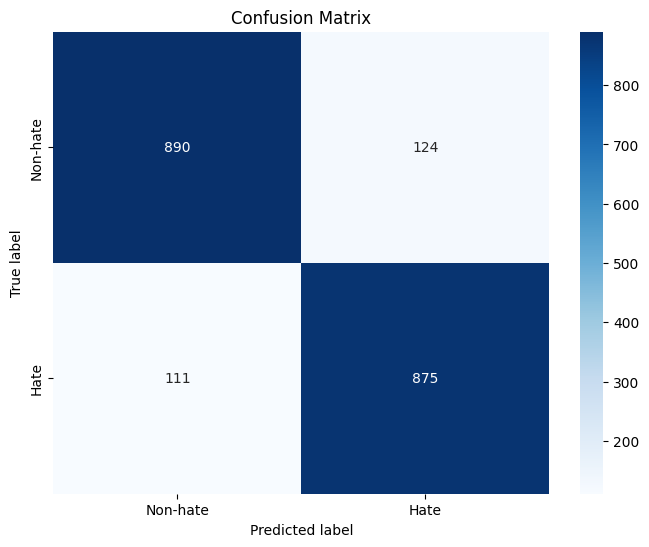

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-hate', 'Hate'], yticklabels=['Non-hate', 'Hate'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# Prediction on user input
def predict_user_input(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
        truncation=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
    if predicted == 0:
        return "Hate Speech"
    else:
        return "Non-hate speech"


In [1]:
user_input = input("Enter a text for evaluation: ")
print(predict_user_input(user_input))

Enter a text for evaluation:  larai karna sahi nahi


NameError: name 'predict_user_input' is not defined

In [ ]:
Allah apko hamesha salamat rakhy

In [10]:
# Saving the trained model and tokenizer
model_save_path = "./hate_speech_model"
tokenizer_save_path = "./tokenizer"

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved.")


Model and tokenizer saved.
